# Migraines and Barometric Pressure Change
- The goal of this notebook is to understand how patients report migraines and if they are associated with pressure chanegs. 


## Q1: Do Subjects Report Migraine's Differently and How?
- If there are two distinct populations based on reporting frequency, we can specify our analysis of how migraines effect depression downstream

### Results
- Does not seem like migraine reporting stratifies in to sub populations with this data set

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
from plot_functions.load_palette import load_palette
import data_processing.import_data as imp
import importlib
import plot_functions.format_axis as fmt

In [5]:
longitudinal_data = imp.import_all_longitudinal_files(clean_only=True)
palette = load_palette()
longitudinal_data.head()

IMPORTING LONGITUDINAL DATA FROM:
	/Users/akre96/Data/DGC_Study/Longitudinal Data with New Barometric Data
	Only importing patients with demographic information, and data until end of study
	Removed 1 subjects 33 remain


,subject_id,Date,Calories (kcal),Distance (mi),Average heart rate (bpm),Max heart rate (bpm),Min heart rate (bpm),Step count,swtype,device_id_call,...,mbrep_sxs_6,mbrep_sxs_other_6,mbrep_auras_6,mbrep_auras_other_6,mbrep_pain_pos_left_6,mbrep_pain_pos_right_6,mbrep_meds_6,mbrep_relief_6,mbrep_notes_6,migraine_buddy_reports_v2_complete_6
0,m2_0049,2018-10-24,NaN,NaN,NaN,NaN,NaN,NaN,Android,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,m2_0049,2018-10-25,NaN,NaN,NaN,NaN,NaN,NaN,Android,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,m2_0049,2018-10-26,NaN,NaN,NaN,NaN,NaN,NaN,Android,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,m2_0049,2018-10-27,NaN,NaN,NaN,NaN,NaN,NaN,Android,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,m2_0049,2018-10-28,NaN,NaN,NaN,NaN,NaN,NaN,Android,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
mig_pain_cols = [col for col in longitudinal_data.columns if 'mbrep_pain_level' in col]

In [28]:
pain_count_df = pd.DataFrame(
    longitudinal_data.groupby('subject_id')[['Date'] + mig_pain_cols].count()
).reset_index()

pain_count_df['mig_pain_logs'] = pain_count_df[mig_pain_cols].sum(axis=1)
pain_count_df['mig_pain_freq'] = pain_count_df['mig_pain_logs']/pain_count_df['Date']

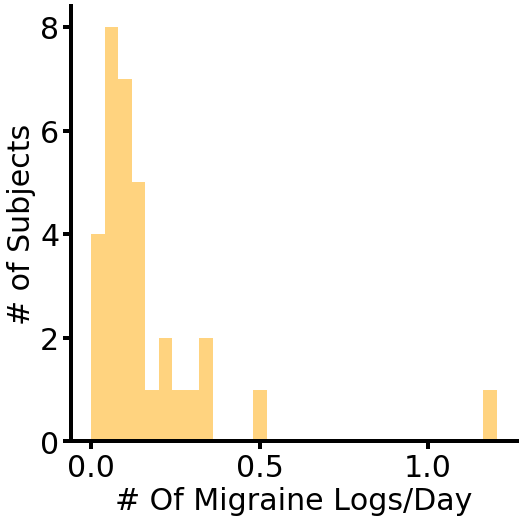

In [36]:
_, ax = plt.subplots(figsize=(8, 8))
ax.hist(
    pain_count_df['mig_pain_freq'],
    alpha=.5,
    color=palette['mbrep_pain_level_1'],
    bins=30
);
fmt.despine_thicken_axes(
    ax=ax,
    lw=4,
    fontsize=30,
    rotate_x=0,
)
ax.set_xlabel('# Of Migraine Logs/Day')
ax.set_ylabel('# of Subjects');

## Q2 How are migraine locations distributed? 

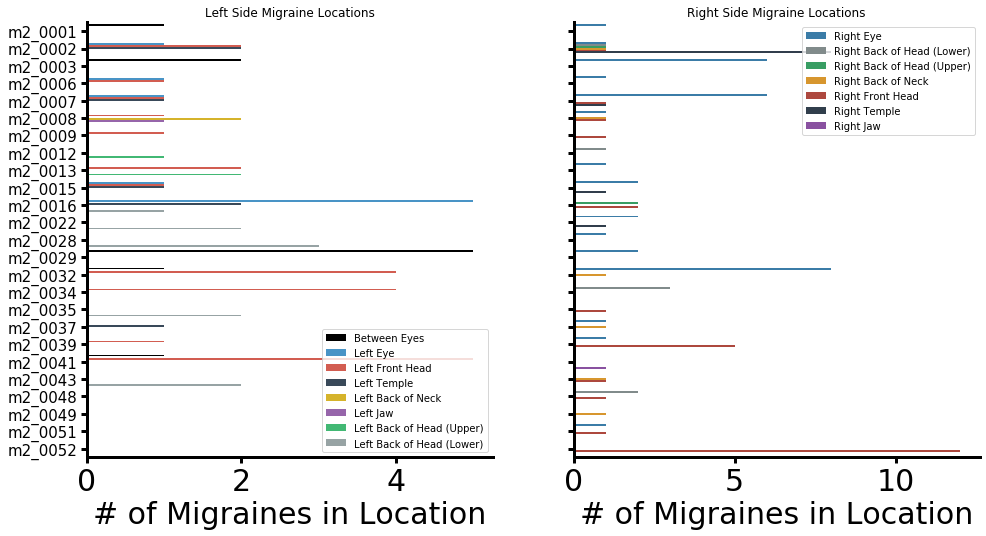

In [102]:
import data_processing.map_data_dict as map_data
import importlib

importlib.reload(map_data)
fig, axes = plt.subplots(ncols=2, figsize=(16, 8), sharey=True)
palette = load_palette()
col_bases = ['mbrep_pain_pos_left', 'mbrep_pain_pos_right']
i=0
for col_base in col_bases:
    pain_cols = [col for col in longitudinal_data.columns if col_base in col]
    pain_df = longitudinal_data[['Date', 'subject_id'] + pain_cols]

    pain_df = pain_df.melt(
        id_vars=['Date', 'subject_id'],
        value_vars=pain_cols,
        var_name=col_base+'_n',
        value_name=col_base
    )
    pain_df.loc[:, col_base + '_str'] = map_data.map_value_from_data_dict(
        pain_df,
        col_base
    )

    ax = axes.flatten()[i]
    count = pd.DataFrame(
        pain_df.groupby(['subject_id', col_base + '_str']).count()
    ).reset_index()


    sns.barplot(
        x=col_base,
        y='subject_id',
        data=count,
        hue=col_base + '_str',
        ax=ax,
        palette=palette[col_base + '_str']
    )

    fmt.despine_thicken_axes(
        ax=ax,
        lw=3,
        fontsize=30,
        rotate_x=0,
        y_tick_fontsize=15
    )
    ax.legend(title='')
    ax.set_title(col_base.split('_')[-1].title() + ' Side Migraine Locations')
    ax.set_xlabel('# of Migraines in Location')
    ax.set_ylabel('')
    i+=1

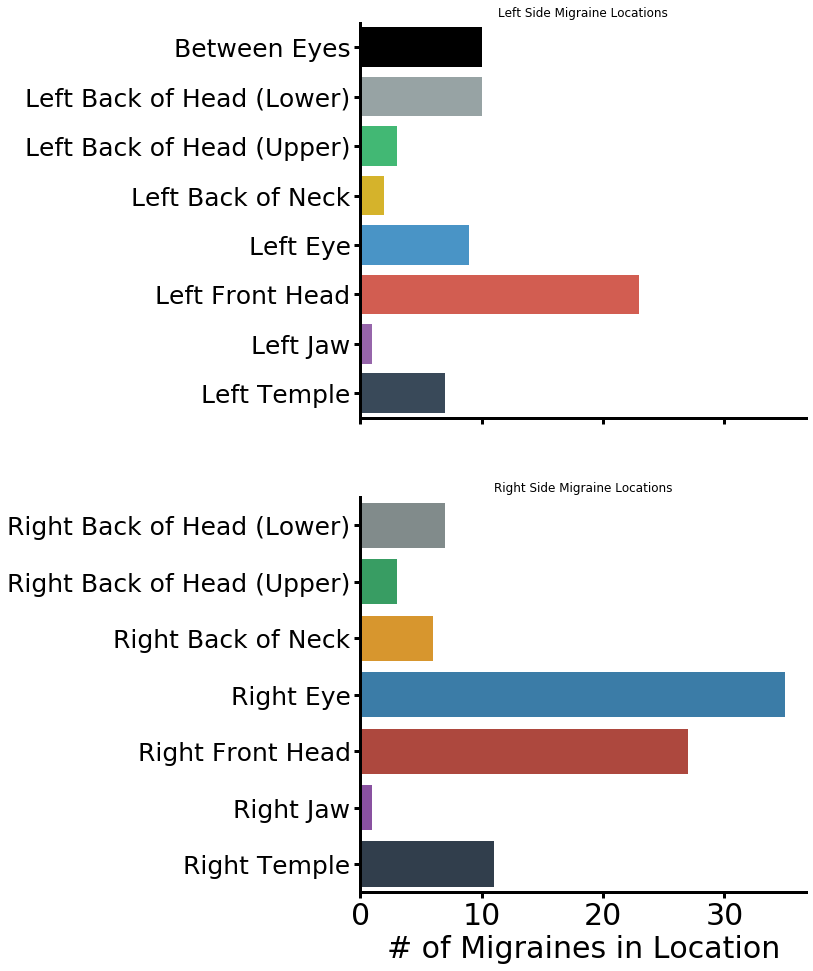

In [158]:
fig, axes = plt.subplots(nrows=2, figsize=(8, 16), sharex=True)
col_bases = ['mbrep_pain_pos_left', 'mbrep_pain_pos_right']
palette = load_palette()
loc_order = {}

i=0
for col_base in col_bases:
    pain_cols = [col for col in longitudinal_data.columns if col_base in col]
    pain_df = longitudinal_data[['Date', 'subject_id'] + pain_cols]

    pain_df = pain_df.melt(
        id_vars=['Date', 'subject_id'],
        value_vars=pain_cols,
        var_name=col_base+'_n',
        value_name=col_base
    )
    pain_df.loc[:, col_base + '_str'] = map_data.map_value_from_data_dict(
        pain_df,
        col_base
    )
    count = pd.DataFrame(
        pain_df.groupby([col_base + '_str'])['Date'].count()
    ).reset_index()
    loc_order[col_base+'_str'] = list(count[col_base + '_str'].unique())
    ax = axes.flatten()[i]
    sns.barplot(
        y=col_base + '_str',
        x='Date',
        data=count,
        ax=ax,
        palette=palette[col_base + '_str']
    )

    fmt.despine_thicken_axes(
        ax=ax,
        lw=3,
        fontsize=30,
        rotate_x=0,
        y_tick_fontsize=25
    )
    ax.set_title(col_base.split('_')[-1].title() + ' Side Migraine Locations')
    ax.set_xlabel('')
    if i:
        ax.set_xlabel('# of Migraines in Location')
    ax.set_ylabel('')
    i+=1

## Q2.1 Do Migraine Locations Co-Occur in left/right side?

In [126]:
level_col_base = 'mbrep_pain_level'

level_cols = [col for col in longitudinal_data.columns if level_col_base in col]
level_df = longitudinal_data[['Date', 'subject_id'] + level_cols]

level_df = level_df.melt(
    id_vars=['Date', 'subject_id'],
    value_vars=level_cols,
    var_name='n_logs',
    value_name=level_col_base
)

level_df['n_logs'] = level_df['n_logs'].str.split('_').str[-1].astype(int)
merged_df = level_df.copy()
for loc_col_base in col_bases:
    print(loc_col_base)
    loc_cols = [col for col in longitudinal_data.columns if loc_col_base in col]
    loc_df = longitudinal_data[['Date', 'subject_id'] + loc_cols]

    loc_df = loc_df.melt(
        id_vars=['Date', 'subject_id'],
        value_vars=loc_cols,
        var_name='n_logs',
        value_name=loc_col_base
    )
    loc_df[loc_col_base + '_str'] = map_data.map_value_from_data_dict(
        loc_df,
        loc_col_base
    )
    loc_df['n_logs'] = loc_df['n_logs'].str.split('_').str[-1].astype(int)
    merged_df = merged_df.merge(
        loc_df,
        how='outer',
        validate='1:1'
    )
merged_df.head()

mbrep_pain_pos_left
mbrep_pain_pos_right


,Date,subject_id,n_logs,mbrep_pain_level,mbrep_pain_pos_left,mbrep_pain_pos_left_str,mbrep_pain_pos_right,mbrep_pain_pos_right_str
0,2018-10-24,m2_0049,1,NaN,NaN,NaN,NaN,NaN
1,2018-10-25,m2_0049,1,NaN,NaN,NaN,NaN,NaN
2,2018-10-26,m2_0049,1,NaN,NaN,NaN,NaN,NaN
3,2018-10-27,m2_0049,1,NaN,NaN,NaN,NaN,NaN
4,2018-10-28,m2_0049,1,NaN,NaN,NaN,NaN,NaN


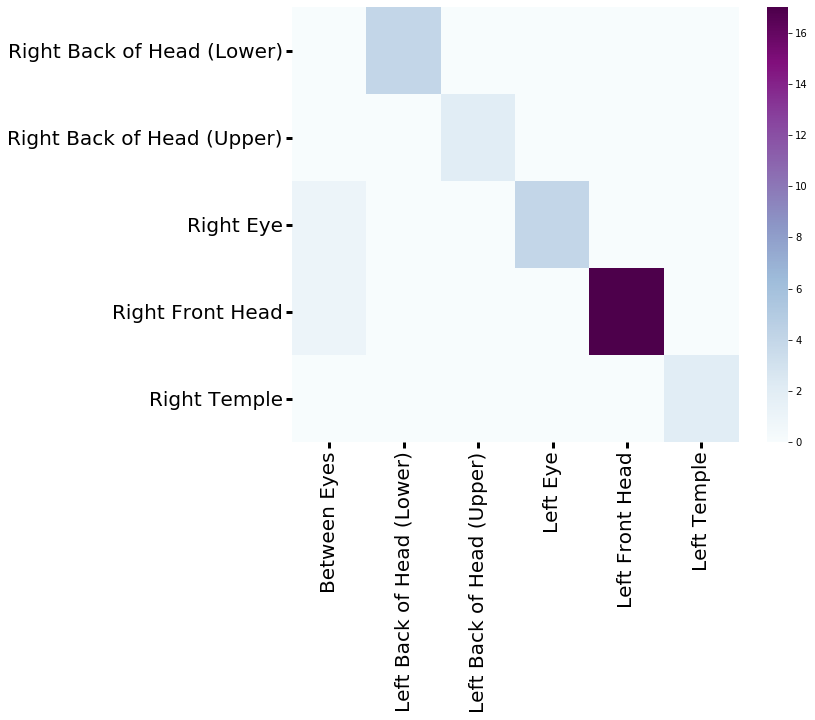

In [187]:
count_df = pd.DataFrame(
    merged_df.groupby(['mbrep_pain_pos_left_str', 'mbrep_pain_pos_right_str'])['Date'].count()
).reset_index()
piv_loc = count_df.pivot_table(
    columns='mbrep_pain_pos_left_str',
    index='mbrep_pain_pos_right_str',
    values='Date',
    fill_value=0,
)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(piv_loc, cmap='BuPu', ax=ax)
ax.tick_params(axis='both', which='major', width=3, length=6, labelsize=20)
ax.set_ylabel('')
ax.set_xlabel('');

## Q2.2 Is migraine location associated with pain severity?

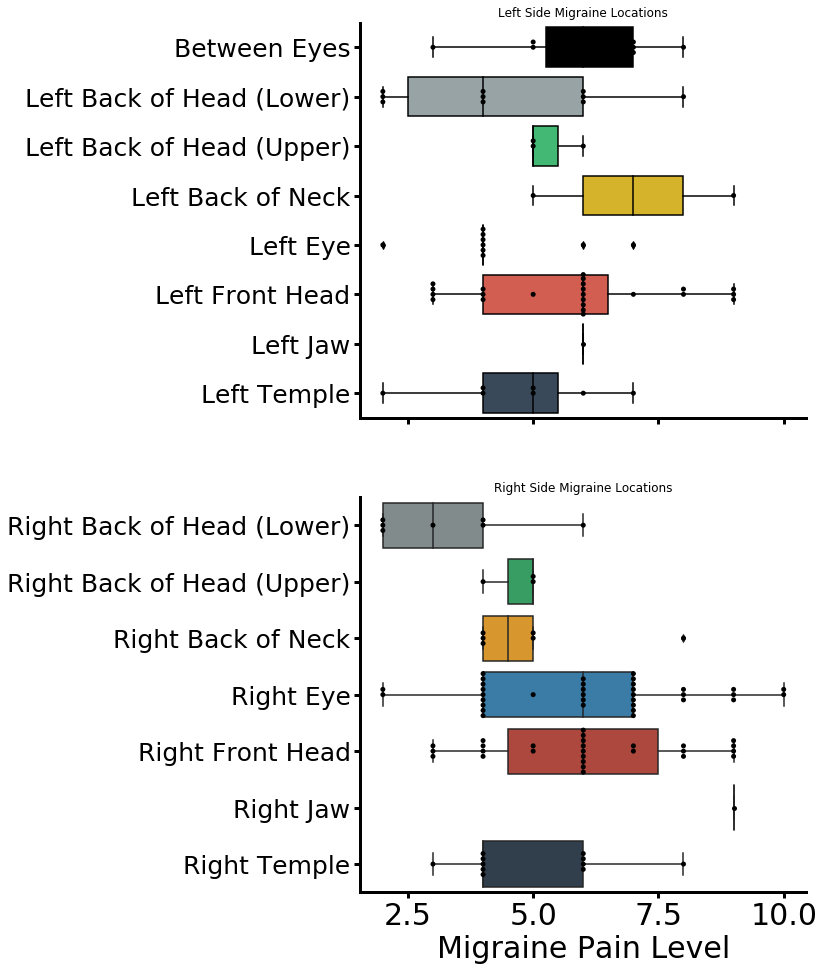

In [159]:
fig, axes = plt.subplots(nrows=2, figsize=(8,16), sharex=True)
i=0
for loc_col_base in col_bases:
    ax = axes[i]
    sns.boxplot(
        y=loc_col_base + '_str',
        x=level_col_base,
        palette=palette[loc_col_base + '_str'],
        order=loc_order[loc_col_base + '_str'],
        ax=ax,
        data=merged_df,
    )
    sns.swarmplot(
        y=loc_col_base + '_str',
        x=level_col_base,
        #hue='subject_id',
        order=loc_order[loc_col_base + '_str'],
        color='black',
        ax=ax,
        data=merged_df
    )
    fmt.despine_thicken_axes(
        ax=ax,
        lw=3,
        fontsize=30,
        rotate_x=0,
        y_tick_fontsize=25
    )
    ax.set_title(loc_col_base.split('_')[-1].title() + ' Side Migraine Locations')
    ax.set_xlabel('')
    ax.set_ylabel('')
    #ax.legend().remove()
    i+=1
ax.set_xlabel('Migraine Pain Level');

## Q3: Do 2 day min max pressure changes predict migraine onset or severity?

## Q3.1: Does controlling for bilateral migraine only show a prediction